<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10회차: CNN을 활용한 컬러 이미지 분류 (4) – 모델 최적화

## 고도화된 CNN 모델 구현

In [1]:
# PyTorch를 이용한 고도화된 CNN 모델 구현
# CIFAR-10 데이터셋을 기반으로 모델 성능 향상을 위해 다양한 기법을 적용한 예제

# 라이브러리 로드
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
# 이미지 전처리와 데이터 증강(Data Augmentation) 을 위한 모듈
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
# 데이터셋 샘플링 시 각 데이터에 다른 확률을 부여해서 뽑을 수 있게 하는 샘플러
from torch.utils.data import WeightedRandomSampler
from collections import Counter

In [13]:
# ================================
# 1. 데이터 전처리 및 증강
# ================================

# 학습 데이터에 다양한 데이터 증강 기법을 적용해 모델의 일반화 성능을 향상
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),            # 이미지를 좌우로 무작위 반전
    transforms.RandomCrop(32, padding=4),         # 4픽셀 패딩 후 32x32 크기로 무작위 크롭
    transforms.ColorJitter(brightness=0.2,        # 밝기 조절
                           contrast=0.2,          # 대비 조절
                           saturation=0.2),       # 채도 조절
    transforms.RandomRotation(10),                # -10도~+10도 범위에서 무작위 회전
    transforms.ToTensor(),                        # PIL 이미지를 Tensor로 변환
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 각 채널별 평균과 표준편차로 정규화
                         (0.2023, 0.1994, 0.2010))
])

# 테스트 데이터는 데이터 증강 없이 정규화만 수행
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

In [17]:
# CIFAR-10 학습/테스트 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

### CNN 구조의 고도화
- 필터(kernel_size=3)는 3 x 3으로 고정
- 합성곱 블록 1 = 합성곱 층 2개 + 최대풀링
- 합성곱 블록 2 = 합성곱 층 2개 + 최대풀링
- 합성곱 블록 3 = 합성곱 층 1개 + 최대풀링
- 완전 연결 층 = 일차원으로 변환해 연결층 1개(256 * 4 * 4 -> 512) + 10개 클래스 분류 층(512 -> 10))



In [14]:
# ================================
# 2. CNN 모델 정의
# ================================

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        # 특징 추출을 위한 Convolutional Layer 블록 정의
        # 이미지 입력을 받아 점점 더 복잡한 특징을 추출하도록 설계된 합성곱 계층 블록
        self.features = nn.Sequential(
            # 첫 번째 블록: 3채널 입력 → 64채널 특징 맵(feature map)으로 변환
            # padding=1 → 출력 크기를 입력과 동일하게 유지 (32×32 → 32×32)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 특징(feature)의 크기는 유지하면서 특징을 “변형”하거나 “추출”하려는 의도
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 32×32 → 16×16
            nn.Dropout(0.25),

            # 두 번째 블록: 64채널 → 128채널
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 16×16 → 8×8
            nn.Dropout(0.25),

            # 세 번째 블록: 128채널 → 256채널
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 8×8 → 4×4
            nn.Dropout(0.3)
        )

        # 완전 연결층 (Flatten 후 Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),  # Conv 결과를 FC 입력으로 변환
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)           # CIFAR-10 클래스 수만큼 출력
        )

    def forward(self, x):
        x = self.features(x)              # Conv 레이어 통과
        x = x.view(x.size(0), -1)         # Flatten
        x = self.classifier(x)            # Fully connected layer 통과
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ImprovedCNN().to(device)  # 모델을 GPU 또는 CPU로 이동
summary(net, (3, 32, 32))       # 모델 구조 요약 출력

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

### 옵티마이저 AdamW(Adam + Weight Decay(W))
-	Adam의 변형: L2 정규화가 개선된 Adam 옵티마이저
  -	큰 가중치에 패널티를 주어 모델이 과적합하지 않도록 제약
	-	결국, 큰 가중치를 감소시켜 더 안정적이고 일반화 잘 되도록 유도
  - L2 정규화: 손실 함수(loss)에 규제 항을 추가해서 가중치가 지나치게 커지지 않도록 제약
	- net.parameters() → 네트워크의 학습 가능한 파라미터들을 optimizer에 전달
	- lr=0.001 → 초기 학습률 설정


In [16]:
# ================================
# 3. 학습 준비
# ================================

criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용 손실 함수
optimizer = optim.AdamW(net.parameters(), lr=0.001)  # Adam의 정규화 강화 버전
# 성능이 정체 상태(plateau)일 때 학습률을 낮추는 스케줄러
# 손실(mode='min') 값이 3번 연속 개선되지 않으면 학습률을 기본값인 10% 줄임
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

## 클래스 불균형(class imbalance) 문제 해결

In [18]:
# ================================
#  데이터 불균형 처리
# ================================
from collections import Counter

# 클래스별 샘플 수 세기 → 불균형 데이터 대응용
targets = trainset.targets
class_count = Counter(targets)  # {클래스: 샘플 수}
print(class_count)
class_weights = [1.0 / class_count[i] for i in targets]  # 빈도에 반비례한 샘플별 가중치 생성
print(class_weights[:10]) # 모두 1/5000 = 0.0002 동일

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]


### 불균형 문제를 해결하는 샘플링 전략 수립
- WeightedRandomSampler를 통해 데이터를 고르게 샘플링하는 전략
- class_weights에 따라 샘플을 확률적으로 선택
- num_samples=len(class_weights):→ 총 샘플 수는 원본 trainset과 동일하게 유지됨 (5만 개)
	- 즉, 전체 데이터 수는 유지하면서, 클래스 등장 비율만 조정
- replacement=True: 중복 허용 → 적은 클래스도 여러 번 뽑힐 수 있음

In [19]:
# 데이터셋 샘플링 시 각 데이터에 다른 확률을 부여해서 뽑을 수 있게 하는 샘플러
from torch.utils.data import WeightedRandomSampler

# 데이터를 고르게 샘플링하는 전략 설정
sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)

### 수립된 샘플링 전략을 DataLoader에 설정
- DataLoader에 sampler를 지정하면, shuffle은 무시
	- sampler는 우리가 만든 균형 샘플링 전략을 그대로 따름
  - 즉, 적은 클래스 데이터를 더 자주 뽑고, 많은 클래스는 덜 뽑는 방식으로 ”학습 데이터를 “확률적으로 균형 있게 재샘플링”하는 전략
- batch_size=128
	- 매 배치마다 다양한 클래스가 비슷한 비율로 포함되도록 샘플링됨
- num_workers=2
	- 데이터 준비 속도를 2배 병렬화해서 모델 학습 흐름을 끊기지 않게 만들어주는 설정


In [ ]:
# WeightedRandomSampler를 이용한 불균형 보정 학습 데이터로더 생성
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=sampler, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

### 고도화된 CNN 모델 학습
- GPU 사용: 약 20분 소요
- CPU 사용: 약 4~5시간 소요

In [20]:
# ================================
# 4. 학습 루프
# ================================

epochs = 30
train_losses = []     # 에폭별 학습 손실
test_accuracies = []  # 에폭별 테스트 데이터 정확도

for epoch in range(epochs):
    net.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()               # 이전 gradient 초기화
        outputs = net(inputs)               # 순전파
        loss = criterion(outputs, labels)   # 손실 계산
        loss.backward()                     # 역전파
        optimizer.step()                    # 파라미터 갱신

        running_loss += loss.item()         # 배치별 손실값 누적

    # 에폭별 손실 값 구해 train_losses에 추가
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # 테스트 정확도 평가
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 에폭별 테스트 데이터 정확도를 구해 test_accuracies에 추가
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    # 학습률을 낮추는 스케줄러의 모니터링 지표(metric)로 평균 손실(avg_loss) 값을 기준으로 지정
    # 즉, 손실이 더 이상 개선되지 않을 때 학습률을 낮춰 모델의 학습을 안정화시키는 방법
    scheduler.step(avg_loss)

    print(f'[Epoch {epoch+1:2d}] Loss: {avg_loss:.3f} | Accuracy: {accuracy:.2f}%')

[Epoch  1] Loss: 1.946 | Accuracy: 43.06%
[Epoch  2] Loss: 1.557 | Accuracy: 53.53%
[Epoch  3] Loss: 1.403 | Accuracy: 59.88%
[Epoch  4] Loss: 1.280 | Accuracy: 61.28%
[Epoch  5] Loss: 1.204 | Accuracy: 66.55%
[Epoch  6] Loss: 1.134 | Accuracy: 66.56%
[Epoch  7] Loss: 1.080 | Accuracy: 69.10%
[Epoch  8] Loss: 1.033 | Accuracy: 71.00%
[Epoch  9] Loss: 1.007 | Accuracy: 73.67%
[Epoch 10] Loss: 0.972 | Accuracy: 74.11%
[Epoch 11] Loss: 0.943 | Accuracy: 74.19%
[Epoch 12] Loss: 0.917 | Accuracy: 76.37%
[Epoch 13] Loss: 0.882 | Accuracy: 77.14%
[Epoch 14] Loss: 0.866 | Accuracy: 77.09%
[Epoch 15] Loss: 0.841 | Accuracy: 78.81%
[Epoch 16] Loss: 0.822 | Accuracy: 79.32%
[Epoch 17] Loss: 0.801 | Accuracy: 80.45%
[Epoch 18] Loss: 0.783 | Accuracy: 78.96%
[Epoch 19] Loss: 0.758 | Accuracy: 80.94%
[Epoch 20] Loss: 0.744 | Accuracy: 81.49%
[Epoch 21] Loss: 0.725 | Accuracy: 80.85%
[Epoch 22] Loss: 0.709 | Accuracy: 82.11%
[Epoch 23] Loss: 0.686 | Accuracy: 83.04%
[Epoch 24] Loss: 0.675 | Accuracy:

In [21]:
%config InlineBackend.figure_format = 'retina'

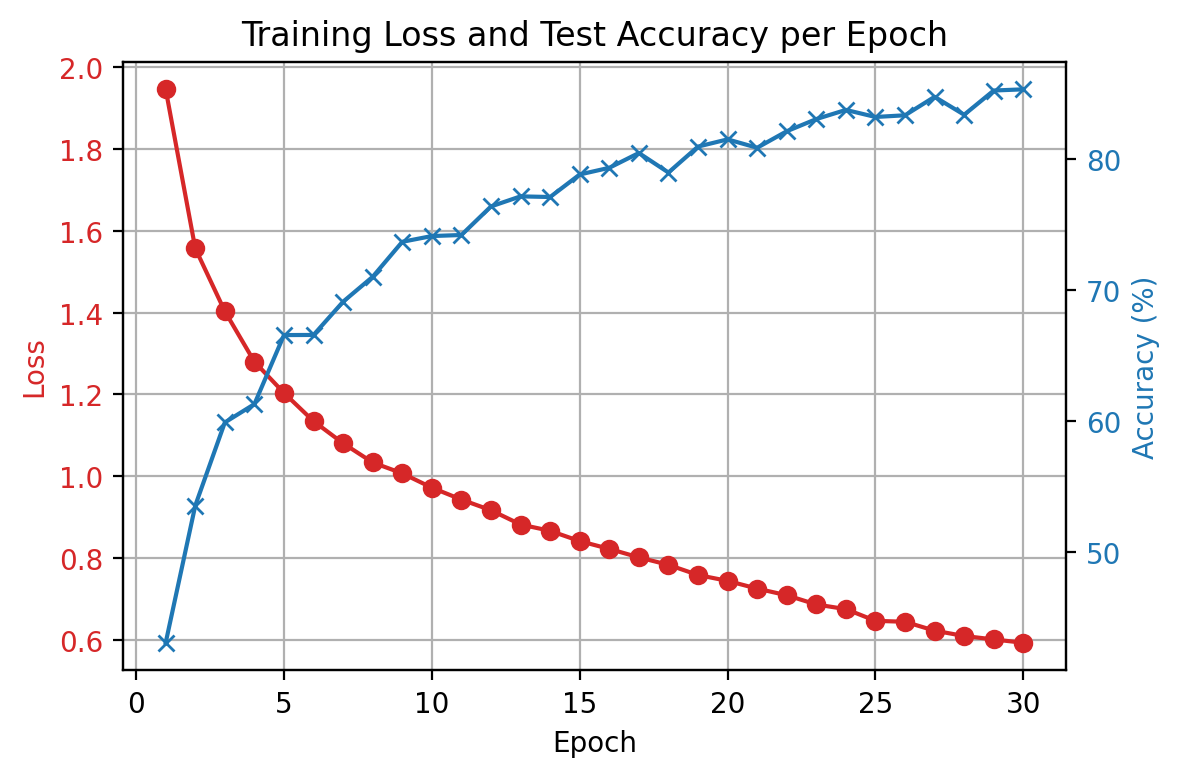

In [22]:
# matplotlib 라이브러리에서 그래프를 그리기 위한 pyplot 모듈 임포트
import matplotlib.pyplot as plt

# 손실과 정확도를 함께 시각화하는 함수 정의
def plot_loss_and_accuracy_together(train_losses, test_accuracies):
    # 에폭 번호 리스트 생성 (1부터 시작)
    epochs = range(1, len(train_losses) + 1)

    # 하나의 figure와 기본 축(ax1)을 생성 (그래프 크기는 6x4인치)
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # === 왼쪽 Y축: 손실(Loss) ===
    color = 'tab:red'  # 손실 곡선은 빨간색으로
    ax1.set_xlabel('Epoch')  # X축 라벨: 에폭 번호
    ax1.set_ylabel('Loss', color=color)  # 왼쪽 Y축 라벨: 손실값
    ax1.plot(epochs, train_losses, color=color, marker='o', label='Loss')  # 손실 곡선 그리기 (동그라미 마커 사용)
    ax1.tick_params(axis='y', labelcolor=color)  # 왼쪽 Y축 눈금 색상도 빨간색으로
    ax1.grid(True)  # 배경에 그리드 표시 (보기 편하게)

    # === 오른쪽 Y축: 정확도(Accuracy) ===
    ax2 = ax1.twinx()  # ax1과 X축을 공유하는 새로운 Y축 생성
    color = 'tab:blue'  # 정확도 곡선은 파란색으로
    ax2.set_ylabel('Accuracy (%)', color=color)  # 오른쪽 Y축 라벨
    ax2.plot(epochs, test_accuracies, color=color, marker='x', label='Accuracy')  # 정확도 곡선 그리기 (X 마커 사용)
    ax2.tick_params(axis='y', labelcolor=color)  # 오른쪽 Y축 눈금 색상 파란색

    # 전체 그래프 제목 설정
    plt.title('Training Loss and Test Accuracy per Epoch')

    # 레이아웃 자동 조정 (레이블 겹침 방지)
    fig.tight_layout()

    # 최종 그래프 화면에 출력
    plt.show()

# 함수 호출: 손실과 정확도 그래프 그리기
plot_loss_and_accuracy_together(train_losses, test_accuracies)

### 수업 종료

### 심화학습: 데이터 증강 후 이미지 데이터 시각화

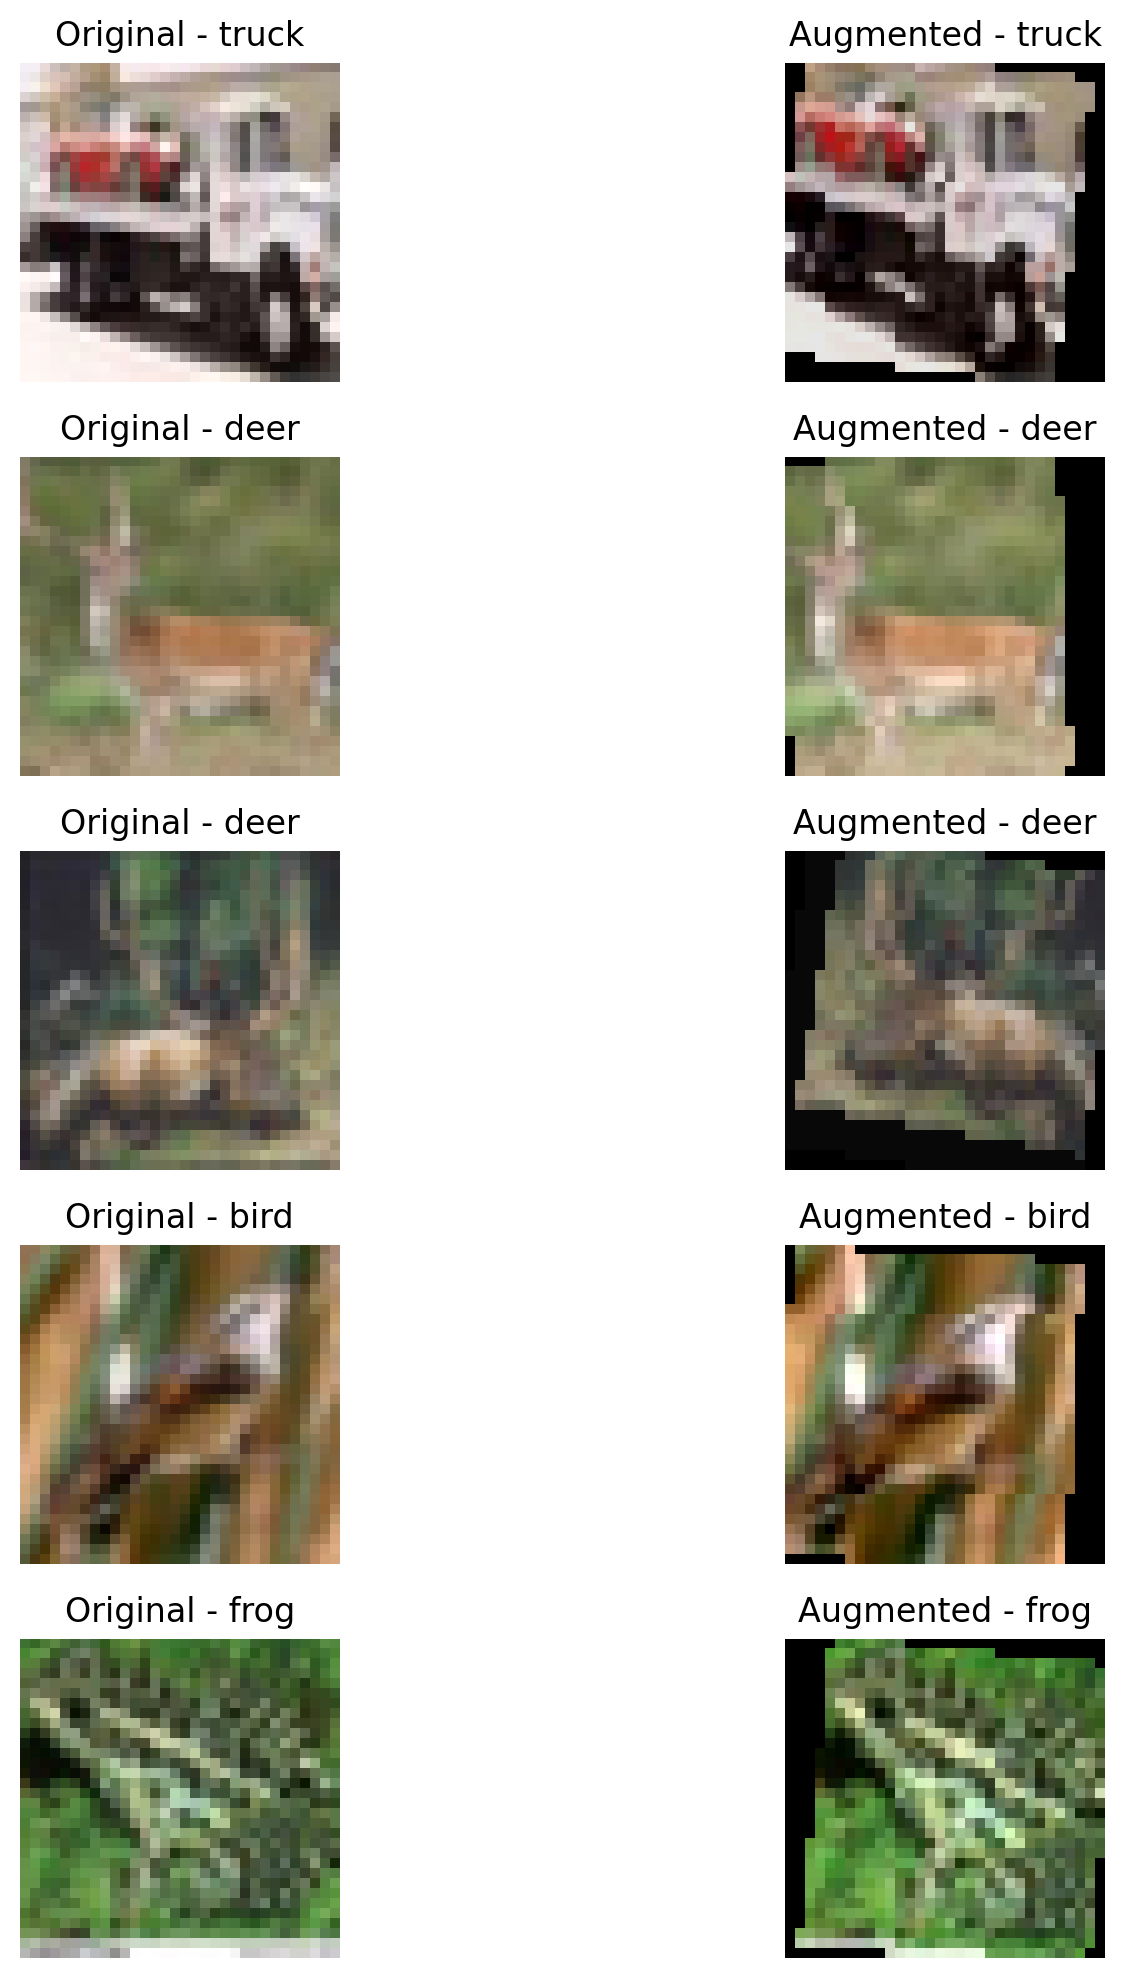

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# 시드 고정 (재현 가능성)
torch.manual_seed(42)
random.seed(42)

# CIFAR10 원본 데이터 (transform 없음)
dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=None)

# 데이터 증강 적용
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform_aug)

# 클래스 이름 가져오기
classes = dataset_raw.classes

# 원본과 증강 이미지 비교 시각화
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 샘플 이미지 출력
plt.figure(figsize=(10, 10))
for i in range(5):
    idx = random.randint(0, len(dataset_raw)-1)
    img_raw, label = dataset_raw[idx]
    img_aug, _ = dataset_aug[idx]

    # 원본과 증강 이미지 나란히 출력
    plt.subplot(5, 2, 2*i+1)
    imshow(transforms.ToTensor()(img_raw), title=f"Original - {classes[label]}")

    plt.subplot(5, 2, 2*i+2)
    imshow(img_aug, title=f"Augmented - {classes[label]}")

plt.tight_layout()
plt.show()

## 종료